In [1]:
%matplotlib inline
# Uncomment from full output from cells
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

In [2]:
import glob
import pandas as pd
import numpy as np
import math
import random
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import entropy
from sklearn.metrics import precision_score, recall_score
from scipy.spatial import distance
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime

# Préparation

## Chargement des données

In [3]:
filenames = glob.glob('./datasets/WISENT-CIDDS-001/CIDDS-001/traffic/OpenStack/*csv')

timestamp_col = 'Date first seen'
src_ip_col = 'Src IP Addr'
src_port_col = 'Src Pt'
dst_ip_col = 'Dst IP Addr'
dst_port_col = 'Dst Pt'
class_col = 'class'
attack_type = 'attackType'
attack_id = 'attackID'
attack_description = 'attackDescription'
protocol = 'Proto'
flags = 'Flags'

src_ip_entropy = 'Src IP entropy'
src_port_entropy = 'Src Pt entropy'
dst_ip_entropy = 'Dst IP entropy'
dst_port_entropy = 'Dst Pt entropy'
flags_entropy = 'Flags entropy'

def load_data(filenames):
    dfs = []
    for filename in filenames:
        df = pd.read_csv(filename,
                               dtype={src_ip_col: 'string', src_port_col: 'string', 
                                      dst_ip_col: 'string', dst_port_col: 'string',
                                      class_col: 'string', attack_type: 'string', 
                                      attack_id: 'string', attack_description: 'string',
                                     protocol: "string", flags: "string"}, 
                               parse_dates=[timestamp_col],
                               index_col=timestamp_col,
                               usecols=[timestamp_col, src_ip_col, src_port_col, 
                                        dst_ip_col, dst_port_col, 
                                        class_col, attack_type, 
                                        attack_id, attack_description, protocol, flags])        
        df['Source'] = filename
        dfs.append(df)
        
    return pd.concat(dfs)

dfs = load_data(filenames)

In [4]:
start_col = 'start'
end_col = 'end'
activity_col = 'activity'
activity_id_col = 'activityID'
description_col = 'description'

attacks_df = pd.read_csv("./datasets/WISENT-CIDDS-001/CIDDS-001/attack_logs/attack_logs_intern.csv", dtype={activity_col: 'string', description_col: 'string', activity_id_col: 'string'},
                      parse_dates=[start_col, end_col], usecols=[start_col, end_col, activity_col, description_col, activity_id_col])

In [5]:
features = [src_ip_entropy, src_port_entropy, dst_ip_entropy, dst_port_entropy]

In [6]:
week1 = ('2017-03-15', '2017-03-21')
week2 = ('2017-03-22', '2017-03-28')
week3 = ('2017-04-05', '2017-04-11')
week4 = ('2017-04-12', '2017-04-18')

## Métadonnées datasets (taille, variables, etc.)

In [7]:
dfs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31287933 entries, 2017-03-15 00:01:16.632000 to 2017-04-18 23:59:30.183000
Data columns (total 11 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   Proto              string
 1   Src IP Addr        string
 2   Src Pt             string
 3   Dst IP Addr        string
 4   Dst Pt             string
 5   Flags              string
 6   class              string
 7   attackType         string
 8   attackID           string
 9   attackDescription  string
 10  Source             object
dtypes: object(1), string(10)
memory usage: 2.8+ GB


### Protocoles

In [8]:
dfs[protocol].unique()

<StringArray>
['TCP  ', 'UDP  ', 'IGMP ', 'ICMP ']
Length: 4, dtype: string

### Flux d'attaque

In [9]:
len(dfs[dfs[attack_id] != '---'])

3236027

### Flux normaux

In [10]:
len(dfs)

31287933

## Filtrage

In [11]:
dfs = dfs[dfs[protocol] != 'IGMP ']

## Aggregation temporelle, calcul de l'entropie

In [12]:
def build_buckets(df, bucket_size):
    # Bucket creation
    buckets = df.groupby(pd.Grouper(level=timestamp_col, freq=bucket_size))
    
    def entropy_and_label_builder(group):
        # Calculate entropy of each feature
        result = group.apply(lambda x: entropy(np.unique(x, return_counts=True)[1]))
        
        # For each group calculate the total number of flows and the number of flows participating in an attack
        result['Num flows'] = len(group)
        result['Num attack flows'] = len(group[group[attack_id] != '---'])
        
        result['Attacks IDs'] = ", ".join(map(lambda x: str(x), group[attack_id].unique()))
                             
        return result.drop(attack_id)
    
    entropy_per_bucket = buckets.apply(entropy_and_label_builder)
    # Renommer les colonnes, elles représentent l'entropie désormais
    return entropy_per_bucket.rename({src_ip_col: src_ip_entropy,
                                      src_port_col: src_port_entropy,
                                      dst_ip_col: dst_ip_entropy,
                                      dst_port_col: dst_port_entropy,
                                      flags: flags_entropy},
                                     axis = 1)

In [13]:
bucket_size = '10min'

# Build buckets in a loop to avoid empty buckets between the ranges
ranges = [('2017-03-15', '2017-03-22 11:00:00'), ('2017-03-22 14:00:00', '2017-03-26 01:59:59'), ('2017-03-26 03:00:00', '2017-03-28'), ('2017-04-05', '2017-04-18')]

X = None
for x in ranges:
    buckets = build_buckets(dfs.loc[x[0]:x[1]][[src_ip_col, src_port_col, dst_ip_col, dst_port_col, flags, attack_id]], bucket_size)
    X = buckets if X is None else pd.concat([X, buckets])

# Phase exploratoire

## Correlation des variables

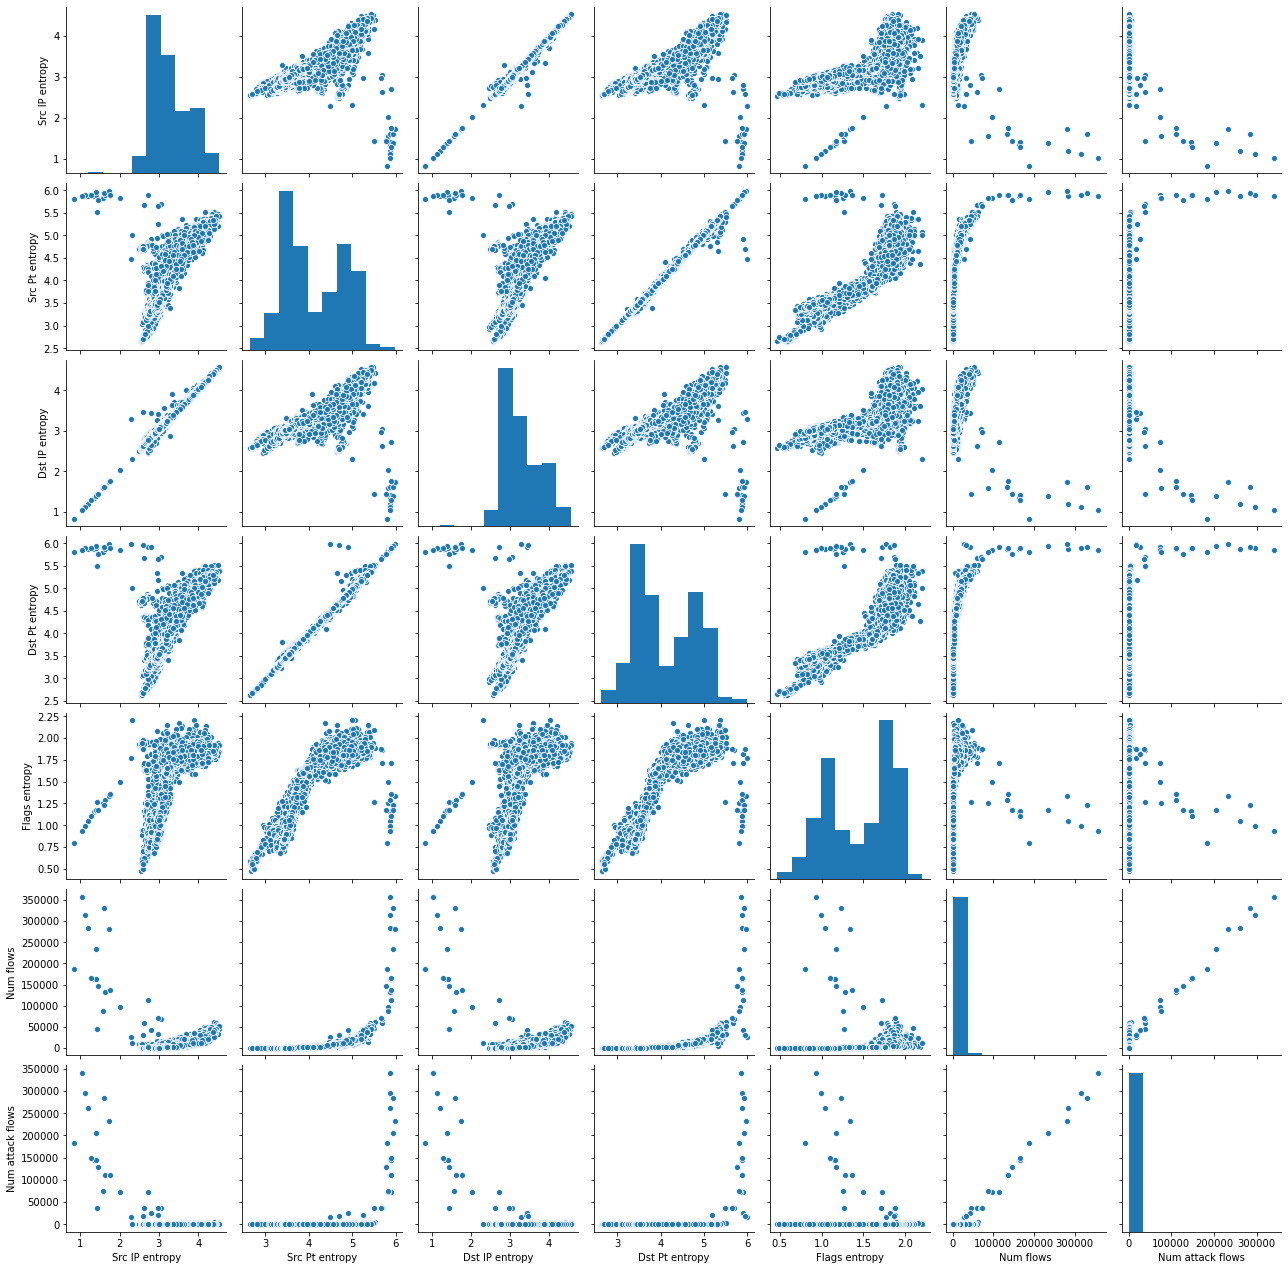

In [14]:
g = sns.pairplot(X)

In [15]:
X.corr()

,Src IP entropy,Src Pt entropy,Dst IP entropy,Dst Pt entropy,Flags entropy,Num flows,Num attack flows
Src IP entropy,1.000000,0.784646,0.992967,0.775391,0.717461,0.276998,-0.228754
Src Pt entropy,0.784646,1.000000,0.788504,0.997305,0.902581,0.598455,0.157572
Dst IP entropy,0.992967,0.788504,1.000000,0.782209,0.722786,0.275085,-0.229331
Dst Pt entropy,0.775391,0.997305,0.782209,1.000000,0.904895,0.598212,0.160416
Flags entropy,0.717461,0.902581,0.722786,0.904895,1.000000,0.327412,-0.039281
Num flows,0.276998,0.598455,0.275085,0.598212,0.327412,1.000000,0.824241
Num attack flows,-0.228754,0.157572,-0.229331,0.160416,-0.039281,0.824241,1.000000


## Visualisation de l'entropie par intervalles de 10 min

In [16]:
def plot_2d(df, features, figsize, colors=None, ylim=None):    
    for i, feature in enumerate(features):
        plt.figure(figsize=figsize)
        plt.title(feature)
        bars = plt.bar(range(len(df)), df[feature], width=1)
        
        if colors and len(colors) == len(bars):
            for i in range(len(bars)):
                bars[i].set_color(colors[i])
        
        # 1 tick per day
        xticks_index = [i for i in range(len(df)) if df.index[i].hour == 0 and df.index[i].minute == 0]
        plt.xticks(xticks_index, [df.index[i].strftime("%D") for i in xticks_index], rotation=90)
        plt.ylim(top=ylim)
        plt.show()

In [17]:
def plot_3d(df, title, colors=['r', 'g', 'b', 'y'], zoom=1):
    fig = plt.figure()
    w, h = fig.get_size_inches()
    fig.set_size_inches(w * zoom, h * zoom)

    ax = fig.add_subplot(111, projection = "3d")
    ax.set_title(title)

    ax.set_xlabel("bin")
    ax.set_ylabel("Variable") 
    ax.set_zlabel("Entropie")

    to_display = df.reset_index()
    
    xticks = to_display[timestamp_col][to_display[timestamp_col].dt.hour == 0]
    
    ax.set_xticks(xticks.index.tolist())
    ax.set_xticklabels(xticks.dt.strftime('%d/%m'), rotation=90)
    ax.set_yticks([0, 1, 2, 3])
    ax.set_yticklabels(features)

    # Convert to matplotlib format
    _x = to_display.index.tolist()
    _y = list(range(len(to_display[features].columns)))
    _xx, _yy = np.meshgrid(_x, _y)

    x, y = _xx.ravel(), _yy.ravel()
    z = np.zeros(len(x))

    dz = to_display[features].values.flatten(order='F')

    for i, color in enumerate(colors):
        start = (int) (i * len(x) / 4)
        end = (int) (start + len(x) / 4)
        ax.bar3d(x[start:end], y[start:end], z[start:end], 1, 1, dz[start:end], shade=True, color=color)

    plt.show()

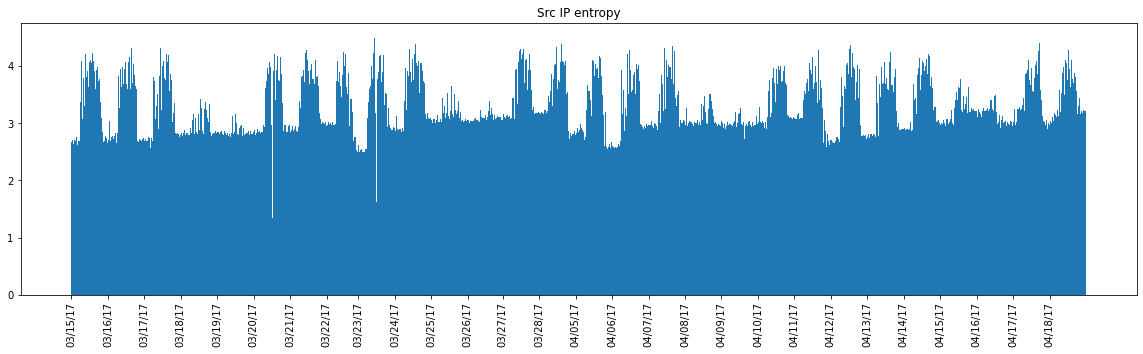

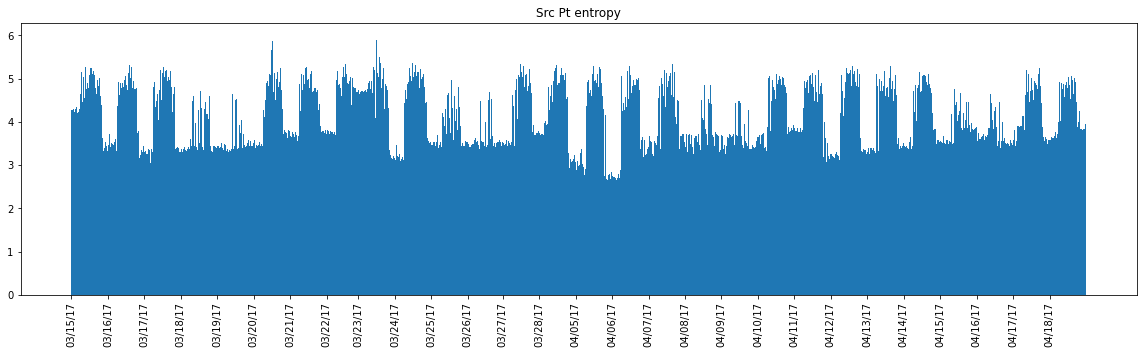

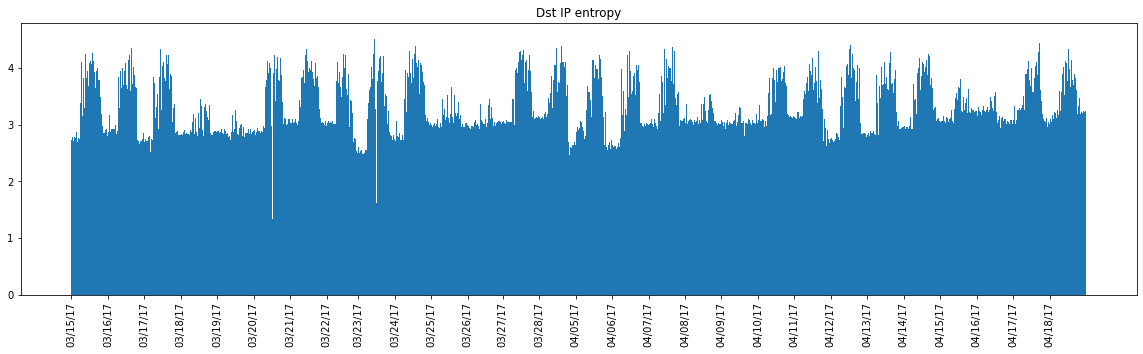

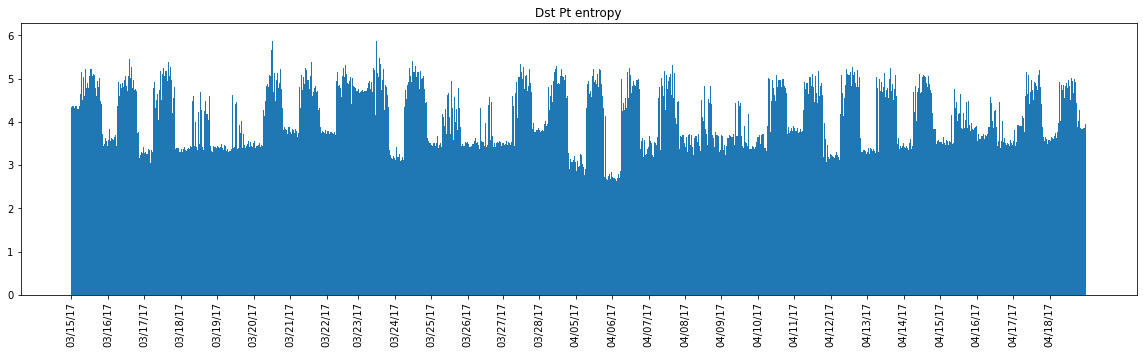

In [18]:
plot_2d(X, features, (20, 5))

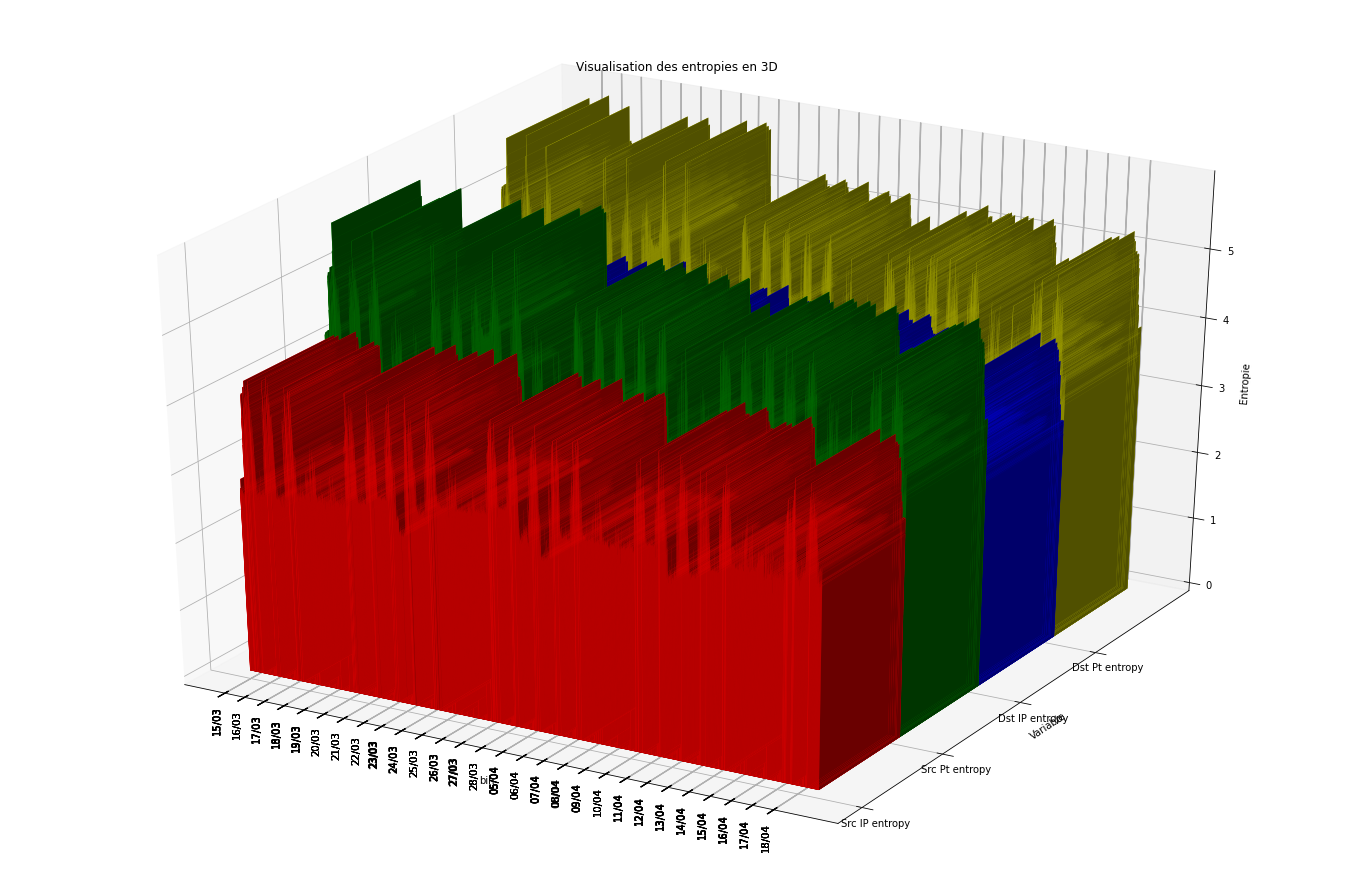

In [19]:
plot_3d(X, "Visualisation des entropies en 3D", zoom=4)

## Visualisation de la chronologie des attaques

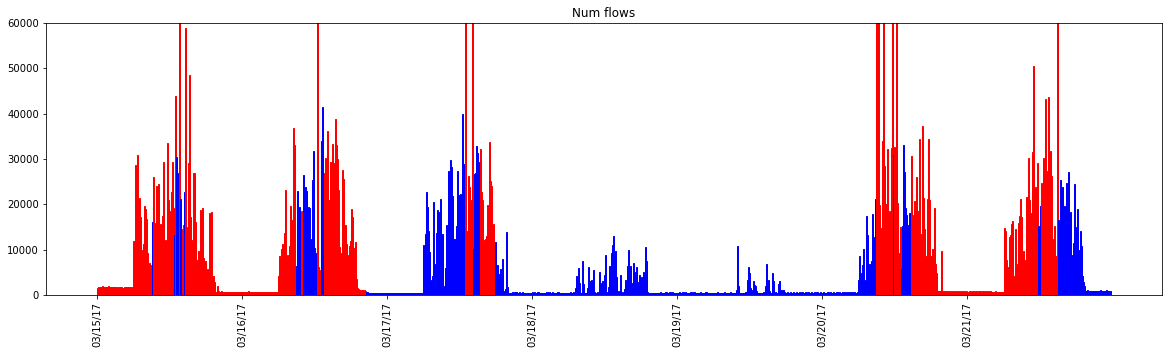

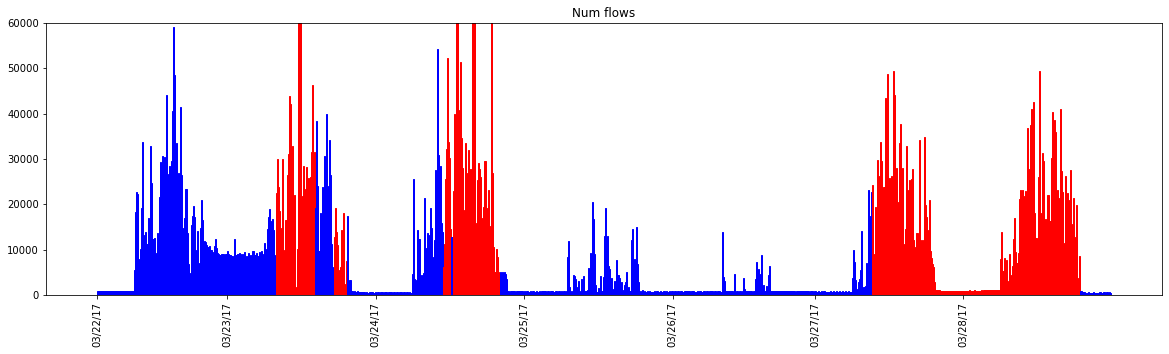

In [20]:
color_map = {True: 'r', False: 'b'}

for week in [week1, week2]:
    to_display = X.loc[week[0]:week[1]]
    attacks = to_display['Num attack flows'] > 0
    plot_2d(to_display, ["Num flows"], (20, 5), colors=attacks.map(lambda x: color_map[x]).values.tolist(), ylim=60000)

## "Taille" des attaques

In [21]:
def plot_2d_stacked(values1, values2, figsize, colors=None, ylim=None):
    fig = plt.figure(figsize=figsize)
    bars = plt.bar(range(len(values1.index)), values1, color='b', width=1)
    
    if colors and len(colors) == len(bars):
        for i in range(len(bars)):
            bars[i].set_color(colors[i])
        
    plt.bar(range(len(values1.index)), values2, color='r', bottom=values1, width=1)
    
    # 1 tick per day
    xticks_index = [i for i in range(len(values1.index)) if values1.index[i].hour == 0 and values1.index[i].minute == 0]
    plt.xticks(xticks_index, [values1.index[i].strftime("%D") for i in xticks_index])

    plt.legend(['Flow normal', 'Flow d\'attaque'], loc=2)
    plt.ylim(top=ylim)
    plt.show()

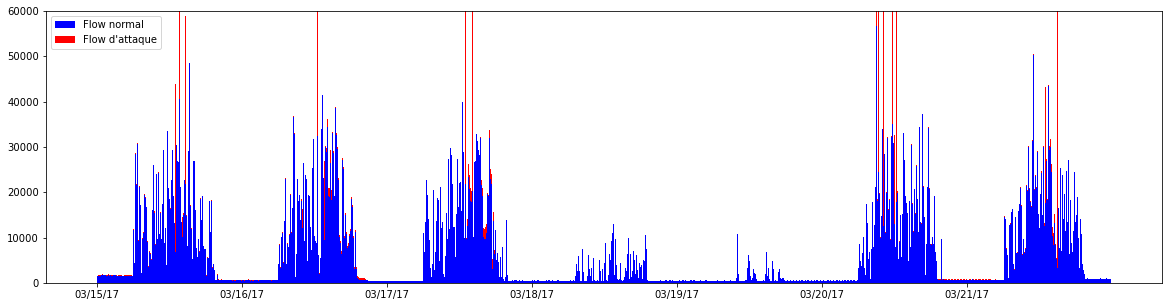

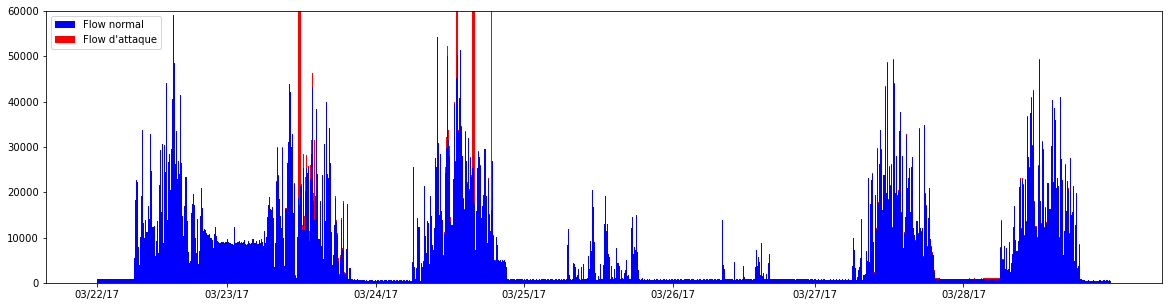

In [22]:
for week in [week1, week2]:
    to_display = X.loc[week[0]:week[1]]
    plot_2d_stacked((to_display["Num flows"] - to_display["Num attack flows"]), to_display["Num attack flows"], (20, 5), ylim=60000)

## Calcul des composantes principales

In [23]:
def train_model(df, n_components, features):
    std_scaler = StandardScaler(with_std=True).fit(df[features])
    transformed = std_scaler.transform(df[features])
    pca = PCA(n_components).fit(transformed)

    return std_scaler, pca


# Selection of number of principal components
n_components = 4

std_scaler, pca = train_model(X, n_components, features)
results = X.copy()

results[features] = std_scaler.transform(results[features])
# Project the data into principal component space
transformed = pca.transform(results[features])

# Add principal components to initial dataframe
for i in range(0, n_components):
    results['PC' + str(i + 1)] = transformed[:, i]

## Analyse des composantes principales 

In [24]:
def print_principal_components(model):
    for i, component in enumerate(model.components_):
        string = f"PC{i+1}: {component[0]} * {features[0]}"
        for j in range(1, len(features)):
            string += f" + {component[j]} * {features[j]}"
        print(string)

In [25]:
print_principal_components(pca)

PC1: 0.49890212874503165 * Src IP entropy + 0.5014363001412718 * Src Pt entropy + 0.5004045022465735 * Dst IP entropy + 0.49925307907479893 * Dst Pt entropy
PC2: -0.5066179161383321 * Src IP entropy + 0.49046987156837085 * Src Pt entropy + -0.4939392260725702 * Dst IP entropy + 0.508725498749758 * Dst Pt entropy
PC3: -0.6716203464626002 * Src IP entropy + -0.2087780538196911 * Src Pt entropy + 0.6833383013155268 * Dst IP entropy + 0.1959249867064675 * Dst Pt entropy
PC4: 0.2082331942769615 * Src IP entropy + -0.681478294758975 * Src Pt entropy + -0.19664216494282116 * Dst IP entropy + 0.67346724459339 * Dst Pt entropy


In [26]:
def scree_plot(pca_model, n_components):
    ind = np.arange(1, n_components + 1)
    (fig, ax) = plt.subplots(figsize=(8, 6))
    sns.barplot(x=ind, y=pca_model.explained_variance_ratio_)

    for i in ind:
        explained_variance_ratio = pca_model.explained_variance_ratio_[i - 1]
        explained_variance = pca_model.explained_variance_[i - 1]
        ax.text(i - 1 - 0.25, explained_variance_ratio / 2, f'{explained_variance:.2f} ({explained_variance_ratio*100:.1f}%)')

    ax.set_title('Eboulis des valeurs propres')
    ax.set_xticklabels(ind)
    ax.set_xlabel("Rang de l'axe d'inertie")
    ax.set_ylabel("Pourcentage d'inertie")

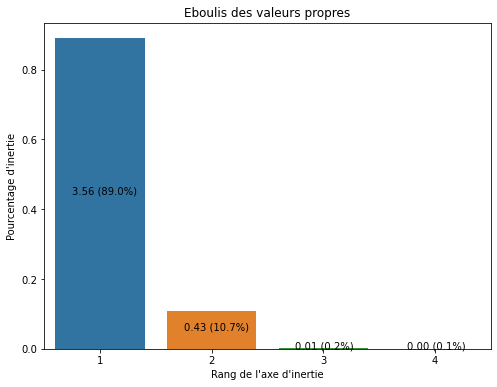

In [27]:
scree_plot(pca, n_components)

## Variabilité des indvidus

In [28]:
def plot_in_pc_space(dfs, n_components):
    plt.figure(figsize=(40, 10))
    for i in range(1, n_components):
        ax = plt.subplot(1, 3, i)
        
        for df in dfs:
            g = sns.scatterplot(
            f'PC1',
            f'PC{i+1}',
            data=df
            )

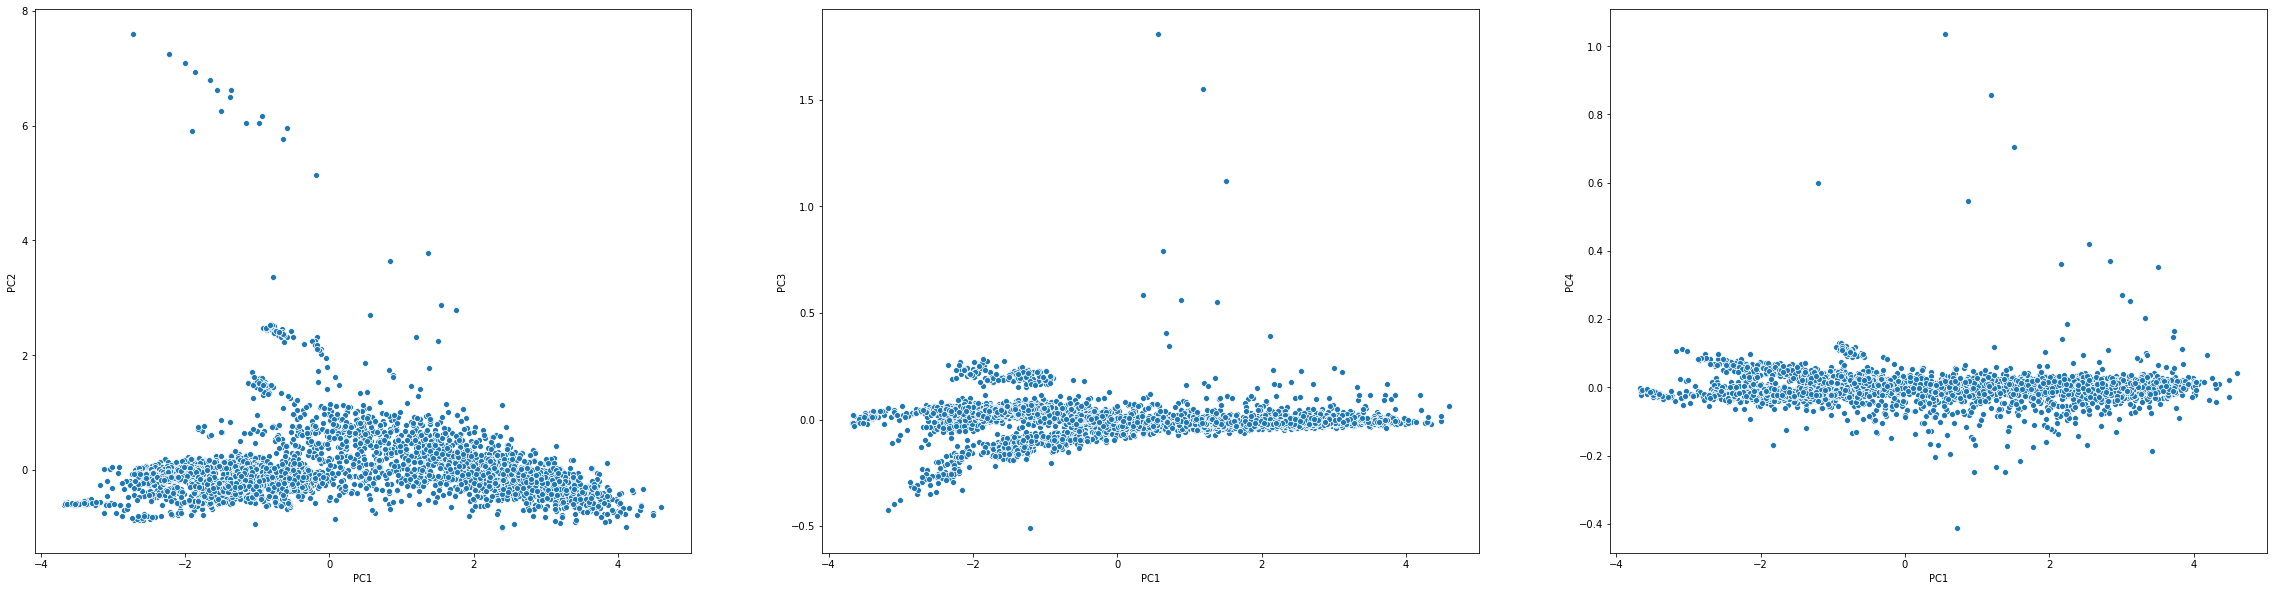

In [29]:
plot_in_pc_space([results], n_components)

## Liasons entre les variables

### Cercle des corrélations

In [30]:
def plot_correlation_circle(pca_model, feature_names, components=(1, 2)):
    (fig, ax) = plt.subplots(figsize=(12, 12))

    for i in range(len(feature_names)):
        ax.arrow(0, 0,  
                 pca_model.components_[components[0] - 1, i], 
                 pca_model.components_[components[1] - 1, i], 
                 head_width=0.05,
                 head_length=0.05)

        plt.text(pca_model.components_[components[0] - 1, i] + 0.05, 
                 pca_model.components_[components[1] - 1, i] + 0.05, 
                 feature_names[i])

    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))
    plt.axis('equal')

    ax.set_title('Cercle des corrélations')
    ax.axhline(y=0, color='k', linestyle='--')
    ax.axvline(x=0, color='k', linestyle='--')
    ax.set_xlabel(f'PC{components[0]}')
    ax.set_ylabel(f'PC{components[1]}')
    plt.grid()
    plt.show()

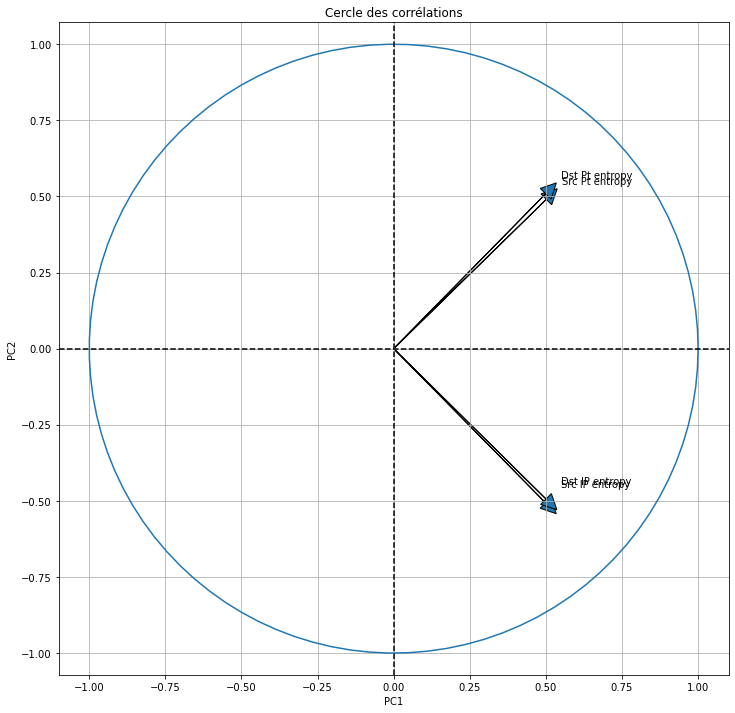

In [31]:
plot_correlation_circle(pca, features)

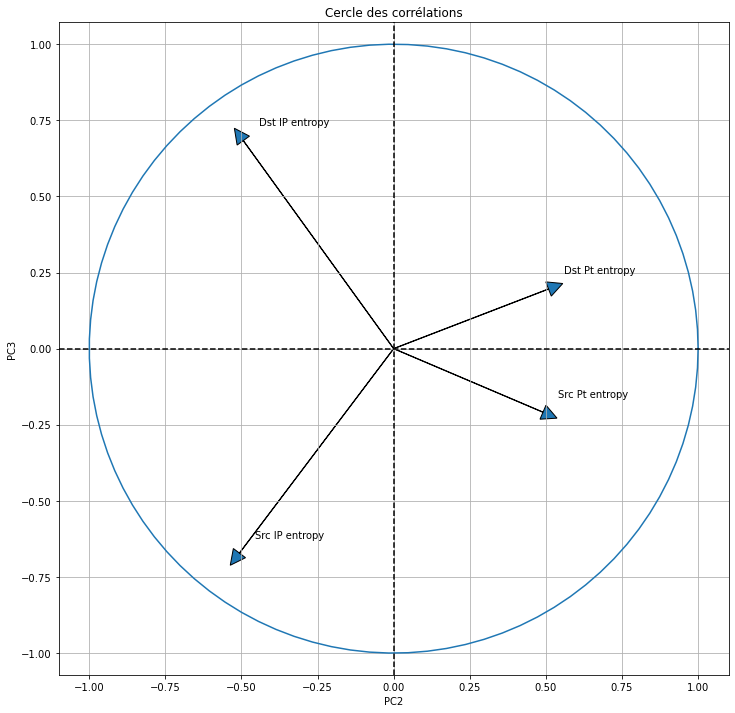

In [32]:
plot_correlation_circle(pca, features, (2, 3))

## Erreur de reconstruction

In [33]:
def calculate_reconstruction_error(pca_model, df, features, n_components, first_component=1):
    components_str = list(map(lambda x: f"PC{x}", range(first_component, n_components + 1)))
    # Project into initial feature space
    reconstructed = np.dot(df[components_str], pca_model.components_[first_component-1:n_components]) + pca_model.mean_
        
    # Distance between initial point and reconstructed points in feature space
    return np.sqrt(np.sum((reconstructed - df[features].values)**2, axis=1))

In [34]:
results['Score'] = calculate_reconstruction_error(pca, results, features, 2)
# Binning of reconstruction error for display purposes
num_bins = 10
results['Score bin'] = pd.cut(results['Score'], bins=num_bins, labels=range(num_bins))

In [35]:
results

,Src IP entropy,Src Pt entropy,Dst IP entropy,Dst Pt entropy,Flags entropy,Num flows,Num attack flows,Attacks IDs,PC1,PC2,PC3,PC4,Score,Score bin
Date first seen,,,,,,,,,,,,,,
2017-03-15 00:00:00,-1.282630,0.233085,-1.204792,0.342691,1.680028,1587.0,125.0,"---, 1",-0.954824,1.533555,0.056638,0.041775,0.070378,0
2017-03-15 00:10:00,-1.161054,0.143463,-1.057181,0.244725,1.665016,1684.0,150.0,"1, ---",-0.914152,1.305256,0.075371,0.033164,0.082345,0
2017-03-15 00:20:00,-1.300325,0.254289,-1.198537,0.359434,1.664146,1724.0,138.0,"---, 1",-0.941530,1.558347,0.071650,0.033687,0.079174,0
2017-03-15 00:30:00,-1.300843,0.171904,-1.240135,0.303797,1.644804,1692.0,129.0,"1, ---",-1.031692,1.510444,0.049872,0.060433,0.078354,0
2017-03-15 00:40:00,-1.184365,0.222390,-1.101432,0.353081,1.662346,1755.0,133.0,"---, 1",-0.854252,1.432758,0.065540,0.056198,0.086335,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-04-18 23:10:00,-0.621830,-0.839731,-0.536541,-0.848338,1.092132,913.0,0.0,---,-1.423327,-0.263385,0.060101,-0.023048,0.064369,0
2017-04-18 23:20:00,-0.197074,-0.361142,-0.234024,-0.341935,1.598132,2065.0,0.0,---,-0.567229,-0.135645,-0.019154,0.020810,0.028283,0
2017-04-18 23:30:00,-0.504635,-0.755975,-0.441423,-0.770608,1.090633,985.0,0.0,---,-1.236455,-0.289117,0.044132,-0.022078,0.049346,0


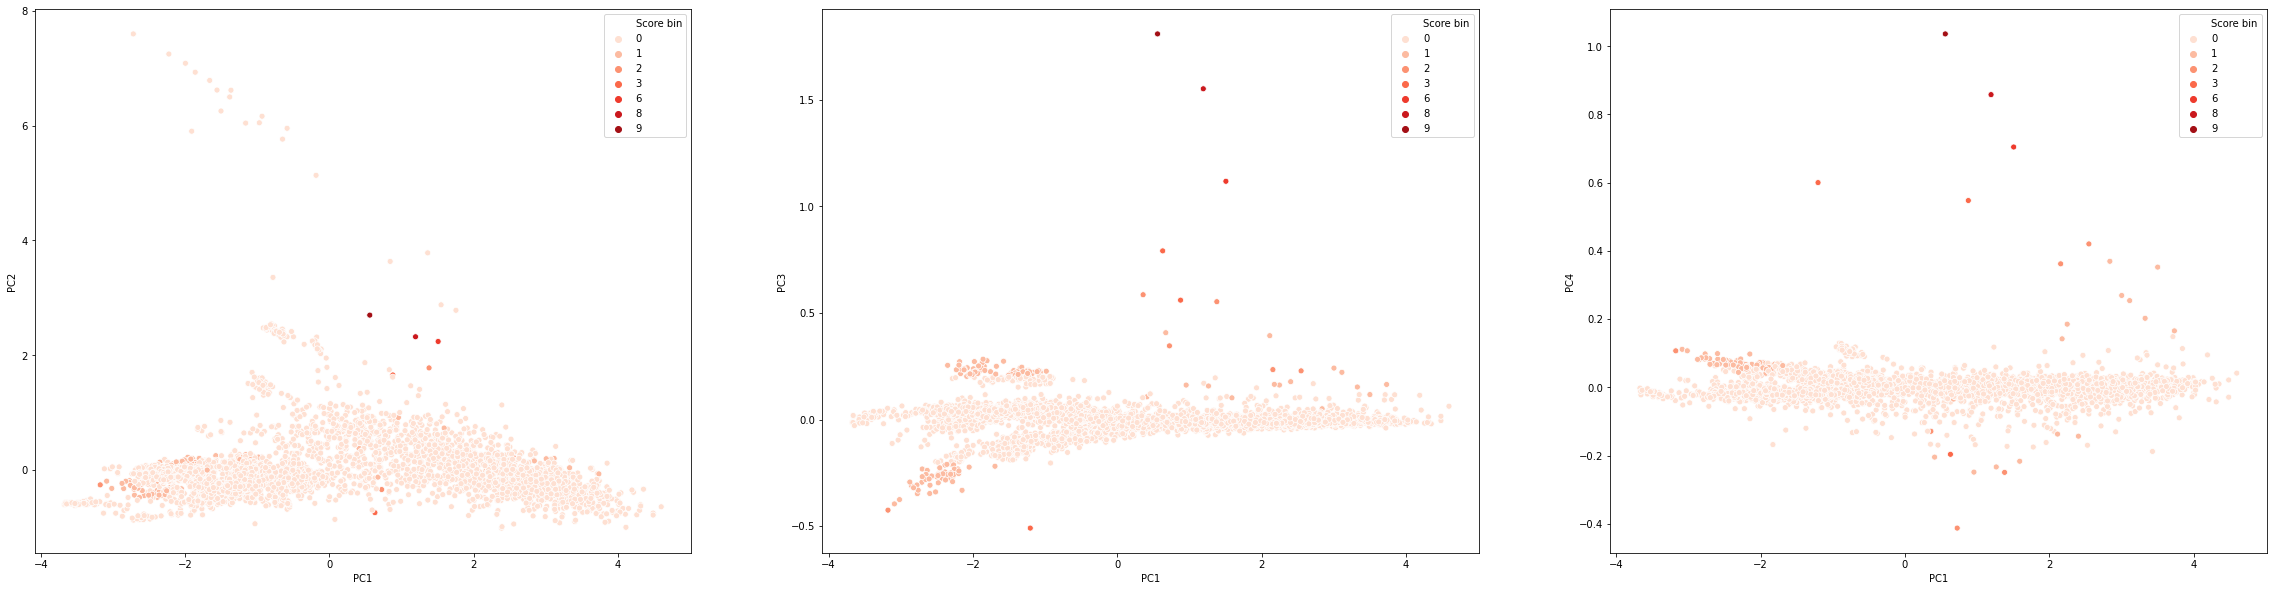

In [36]:
plt.figure(figsize=(40, 10))

for i in range(1, n_components):  
    ax = plt.subplot(1, 3, i)
    g = sns.scatterplot(
        f'PC1',
        f'PC{i+1}',
        data=results,
        hue='Score bin',
        palette=sns.color_palette('Reds', n_colors=
                                  len(np.unique(results['Score bin']))),
        ax=ax
        )

### Top N

In [37]:
results.sort_values(by='Score', ascending=False).head(10)

,Src IP entropy,Src Pt entropy,Dst IP entropy,Dst Pt entropy,Flags entropy,Num flows,Num attack flows,Attacks IDs,PC1,PC2,PC3,PC4,Score,Score bin
Date first seen,,,,,,,,,,,,,,
2017-03-16 13:40:00,-2.088454,0.520561,-0.021597,2.704475,1.770830,26933.0,17401.0,"---, 11",0.558504,2.699870,1.809083,1.035986,2.084718,9
2017-03-23 14:10:00,-1.445408,0.828642,0.340956,2.658945,1.870608,31484.0,17629.0,"---, 49",1.192497,2.322955,1.551705,0.857982,1.773111,8
2017-03-21 13:00:00,-0.987971,1.140707,0.272040,2.585166,1.816412,43295.0,25657.0,"37, ---",1.505873,2.240775,1.117781,0.704435,1.321236,6
2017-03-27 09:40:00,0.117089,-0.078911,1.260346,-0.039706,1.774116,2345.0,248.0,"---, 66",0.629707,-0.740756,0.791299,-0.196420,0.815312,3
2017-04-12 20:00:00,0.011540,-1.048141,-0.926635,-0.443663,1.273504,895.0,0.0,---,-1.205011,-0.287929,-0.509051,0.600111,0.786935,3
2017-03-17 17:30:00,-0.664291,0.762975,-0.104584,1.759929,2.084681,5207.0,2157.0,"20, ---",0.877483,1.657737,0.560206,0.547542,0.783348,3
2017-03-20 12:00:00,-0.636945,1.619954,0.237855,1.535382,1.877176,32709.0,19732.0,"---, 29",1.380098,1.780829,0.552930,-0.249339,0.606549,2
2017-03-16 12:50:00,-0.307970,0.209914,0.539966,0.273939,1.824368,2231.0,199.0,"---, 10",0.358578,0.131629,0.585664,-0.128873,0.599676,2
2017-03-17 20:00:00,0.214493,0.405708,0.846911,-0.021314,1.915152,1698.0,0.0,---,0.723605,-0.338844,0.345790,-0.412709,0.538423,2
